In [1]:
import copy
import math

from Utilities import *
from PuzzlePiece import *
from AlignerTools import *
from SWPuzzleAligner import *
from EuclideanSimilarity import *
from PairwiseDistanceSimilarity import *

In [157]:
# gather all the pieces
target_pieces = {}
tried_pieces = {}

for p in ['C','N','NE','E','SE','S','SW','W','NW']:
    target_pieces[p] = PuzzlePiece('3x3_pieces/' + p + '_border.csv', 
                                   border_sampling_rate = .1, window_size = 1)

In [158]:
# get the first piece
query = target_pieces.pop('C') # this piece serves as the core
tried_pieces['C'] = copy.deepcopy(query) # keep a copy in case we need to go back 

In [175]:
###############################
# REPEAT HERE
##############################
print(target_pieces.keys())

dict_keys(['N', 'NE', 'E', 'SE', 'SW', 'W', 'NW'])


In [176]:
# find the closest match in the other pieces
mx_score = 0
mx_piece = ''

alignments = {}

for i,p in enumerate(target_pieces):
    
    target = target_pieces[p]
    
    # extend the query to account for circular sequence
    tail_length = min(int(len(target_pieces[p].border_sample) * .15),
                      int(len(query.border_sample) * .15))

    query.extend_border_sample(tail_length)
    target.extend_border_sample(tail_length, reverse = True)
    
    Aligner = SWPuzzleAligner(EuclideanSimilarity())
    SuffixTable, mx, mx_Q, mx_T, length = Aligner.Align(
                    M = query.border_sample_ext, 
                    N = target.border_sample_ext,
                    window = 5, cutoff_percentile = 0.01)

#     Aligner = SWPuzzleAligner(PairwiseDistanceSimilarity())
#     SuffixTable, mx, mx_Q, mx_T, length = Aligner.Align(
#                     M = query.sample_dists, 
#                     N = { len(target.sample_dists)-i-1: v for i,v in target.sample_dists.items() }, # has to be reversed and not getting extension
#                     cutoff_percentile = .10)
    
    alignments[p] = { 'SuffTable': SuffixTable,
                      'mx_score': mx,
                      'mx_Q': mx_Q,
                      'mx_T': mx_T,
                      'length': length}
    
    if mx > mx_score:
        mx_score = mx
        mx_piece = p
        
    print(p, mx, mx_Q, mx_T, length, mx/length)

N 20 112 82 23 0.8695652173913043
NE 20 82 92 21 0.9523809523809523
E 19 113 94 22 0.8636363636363636
SE 11 48 91 12 0.9166666666666666
SW 12 156 43 13 0.9230769230769231
W 19 138 49 20 0.95
NW 20 139 42 21 0.9523809523809523


In [183]:
mx_piece = 'N'

In [184]:
mx_alignment = alignments[mx_piece]
SuffTable = mx_alignment['SuffTable']
mx = mx_alignment['mx_score']
mx_Q = mx_alignment['mx_Q']
mx_T = mx_alignment['mx_T']
length = mx_alignment['length']

#target = target_pieces.pop(mx_piece)
target = target_pieces[mx_piece]
print('Best: ', mx_piece, mx, mx_Q, mx_T, length)

Best:  N 20 112 82 23


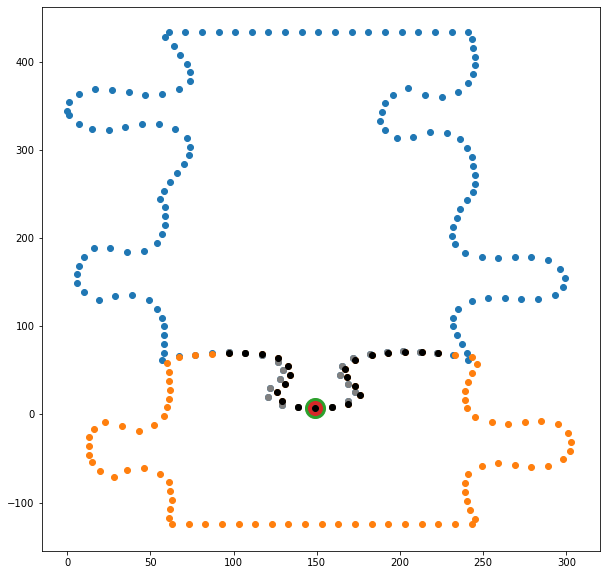

In [185]:
#find the best matched point - this is the end of the best match window
Q_pt = query.border_sample[query.ext_to_old_index[mx_Q-int(length/2)]] # -length/2 aligns to middle of matching region
T_pt = target.border_sample[target.ext_to_old_index[mx_T-int(length/2)]] # this is specific to pairwise distances

# find x,y shift to align pieces based on that one point
T_xshift = T_pt['x'] - Q_pt['x']
T_yshift = T_pt['y'] - Q_pt['y'] 

plt.figure(figsize = [10,10])
plt.scatter( [query.border_sample[k]['x'] for k,v in query.border_sample.items() ],
             [query.border_sample[k]['y'] for k,v in query.border_sample.items() ])
plt.scatter( [target.border_sample[k]['x'] - T_xshift for k,v in target.border_sample.items() ],
             [target.border_sample[k]['y'] - T_yshift for k,v in target.border_sample.items() ])

# show best matched points - second will overplot first due to alignment
plt.scatter( Q_pt['x'], Q_pt['y'], s=400)
plt.scatter( T_pt['x'] - T_xshift, T_pt['y'] - T_yshift, s=196 ) 

# show similarity window
# the black and grey points repsent the points in the positive scoring diagonal
# of the suffix table starting at the maximum scoring point
# these points are the best locally aligned points
Q_window = [query.border_sample[query.ext_to_old_index[q]] for q in range(mx_Q - length, mx_Q)]
plt.scatter( [p['x'] for p in Q_window],
             [p['y'] for p in Q_window], c = 'grey' )

T_window = [target.border_sample[target.ext_to_old_index[t]] for t in range(mx_T - length, mx_T)]
plt.scatter( [p['x'] - T_xshift for p in T_window],
             [p['y'] - T_yshift for p in T_window], c = 'black' )


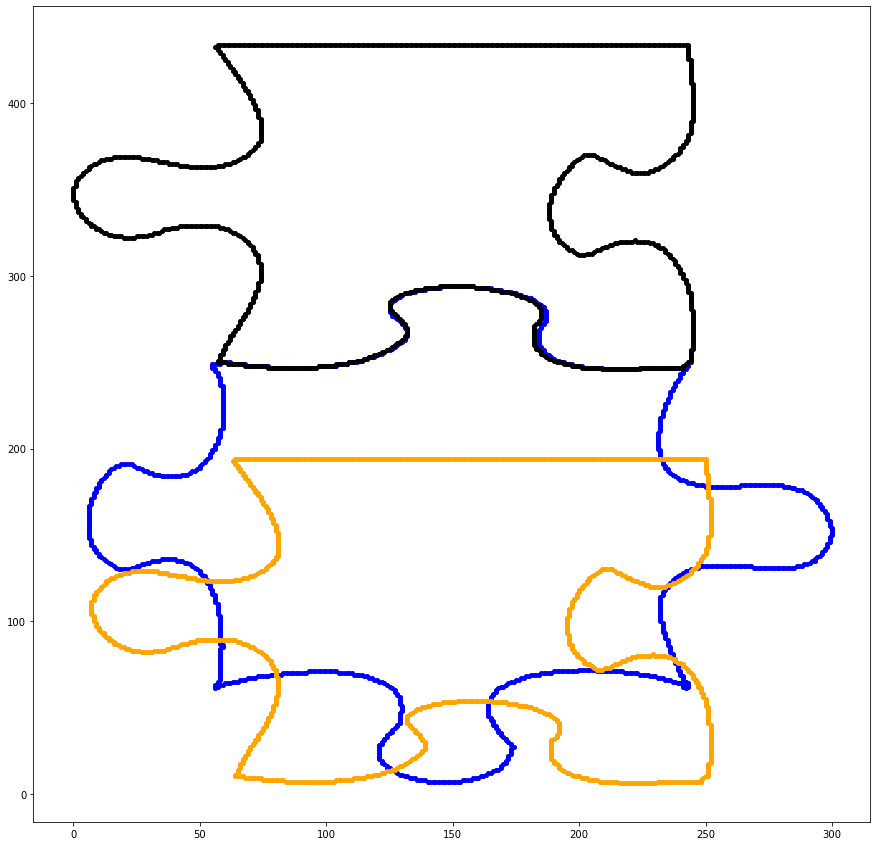

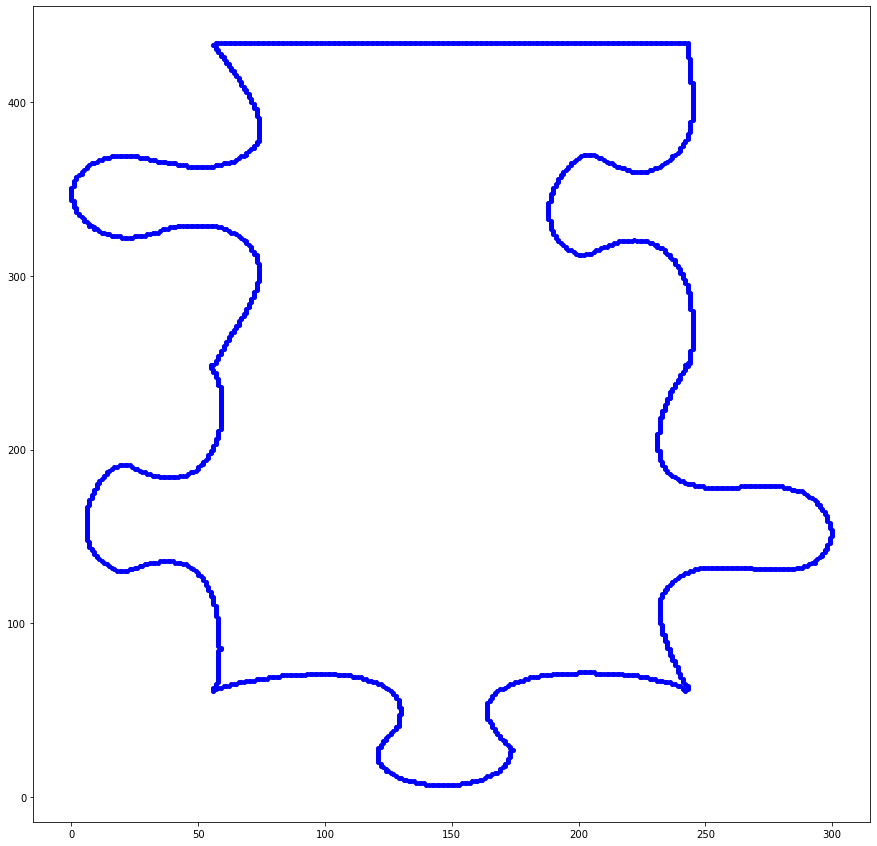

In [173]:
# combine the pieces into one piece
Q_window_pts = [q for q in range(mx_Q-length, mx_Q)]
T_window_pts = [t for t in range(mx_T-length, mx_T)]

Q_x = [ q[1]['x'] for q in query.border.items() ]
Q_y = [ q[1]['y'] for q in query.border.items() ]

T_orig_x = [ t[1]['x'] for t in target.border.items() ]
T_orig_y = [ t[1]['y'] for t in target.border.items() ]

target.reposition(T_window_pts, query, Q_window_pts)

T_shifted_x = [t[1]['x'] for t in target.border.items() ]
T_shifted_y = [t[1]['y'] for t in target.border.items() ]

plt.figure(figsize = [15,15])
plt.scatter( Q_x, Q_y, c = 'blue', s=16)
plt.scatter( T_orig_x, T_orig_y, c = 'orange', s=16)
plt.scatter( T_shifted_x, T_shifted_y, c = 'black', s=16)
#plt.savefig('placement_figs/temp_translation.png')
            
query.merge(target)

Q_merged_x = [ q[1]['x'] for q in query.border.items() ]
Q_merged_y = [ q[1]['y'] for q in query.border.items() ]

plt.figure(figsize = [15,15])
plt.scatter( Q_merged_x, Q_merged_y, c = 'blue', s=16)
#plt.savefig('placement_figs/temp_composite.png')

In [174]:
#########################
# REPEAT ABOVE
#########################
target = target_pieces.pop(mx_piece)